In [31]:
import re
from typing import Final, TypeAlias

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from nltk.corpus import gutenberg
from pandas import DataFrame
from shap import Explainer

from authorship_tool.types import Tag, TwoDimStr
from authorship_tool.util import dim_reshaper, type_guard
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import trainer as lgbm_trainer
from authorship_tool.util.ml.model import LGBMResult, LGBMSource
from authorship_tool.util.path_util import PathUtil

# 必要に応じてダウンロード
nltk.download("gutenberg")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [33]:
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "bryant"

In [34]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")


#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [35]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: list[list[TwoDimStr]] = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]  # type: ignore

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [36]:
books_a: list[list[TwoDimStr]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]  # type: ignore

paras_a: list[TwoDimStr] = [para for paras in books_a for para in paras]
if len(paras_a) == 0 or not type_guard.are_paras(paras_a):
    raise ValueError("paras_a is empty or not list[Para]")

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [37]:
books_b: list[list[TwoDimStr]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]  # type: ignore

paras_b: list[TwoDimStr] = [para for paras in books_b for para in paras]
if len(paras_b) == 0 or not type_guard.are_paras(paras_b):
    raise ValueError("paras_a is empty or not list[list[str]]")

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

[ Stories to Tell to Children by Sara Cone Bryant 1918 ]
TWO LITTLE RIDDLES IN RHYME
There ' s a garden that I ken , Full of little gentlemen ; Little caps of blue they wear , And green ribbons , very fair . ( Flax .)
From house to house he goes , A messenger small and slight , And whether it rains or snows , He sleeps outside in the night . ( The path .)
THE LITTLE YELLOW TULIP
Once there was a little yellow Tulip , and she lived down in a little dark house under the ground . One day she was sitting there , all by herself , and it was very still . Suddenly , she heard a little _tap , tap , tap_ , at the door .
" Who is that ?" she said .
" It ' s the Rain , and I want to come in ," said a soft , sad , little voice .
" No , you can ' t come in ," the little Tulip said .
By and by she heard another little _tap , tap , tap_ on the window - pane .
" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," s

In [38]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")

total: 5249 paragraphs (samples)


In [39]:
if not (type_guard.are_paras(paras_a) and type_guard.are_paras(paras_b)):
    raise TypeError("paras_a or paras_b is not list[Para]")
all_paras: list[TwoDimStr] = paras_a + paras_b

pos_list: list[Tag] = PosFeature(all_paras).tag_subcategories().pos_list

print(pos_list)

['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [40]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=pos_list)


In [41]:
para_and_correctness_list: list[tuple[TwoDimStr, bool]] = list(
    [(para, True) for para in paras_a] + [(para, False) for para in paras_b]
)

In [42]:
dataset, categories = zip(
    *[
        dataset_generator.generate_from_paragraph(para, is_correct)
        for para, is_correct in para_and_correctness_list
    ]
)

In [43]:
df = DataFrame(dataset, columns=dataset_generator.columns)
nd_category = np.array(categories, dtype=bool)

display(df.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains although,v13 contains however,v14 contains but,v15 contains because,v16 contains this,v17 contains others or researchers,v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains et,word variation,average token length,non alphabetic characters frequency,uncommon word frequency,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_pp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.857143,2.857143,0.571429,0.857143,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.071429,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.071429,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,2.0,8.0,0.0,0.0,0.0,0.0,0.0,2.000000,4.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,3.625000,0.125000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,5.0,164.0,0.0,0.0,1.0,0.0,0.0,12.983066,13.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573171,4.103659,0.091463,0.530488,0.0,0.0,0.000000,0.000000,0.042683,0.030488,0.018293,0.048780,0.006098,0.134146,0.000000,0.006098,0.176829,0.073171,0.006098,0.000000,0.0,0.000000,0.164634,0.012195,0.000000,0.036585,0.000000,0.000000,0.060976,0.000000,0.036585,0.000000,0.000000,0.000000,0.0,0.024390,0.0,0.006098,0.042683,0.018293,0.012195,0.012195,0.024390,0.006098,0.0,0.000000,0.000000,0.0
3,6.0,149.0,0.0,1.0,1.0,0.0,0.0,4.669642,6.200000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.637584,4.389262,0.120805,0.590604,0.0,0.0,0.000000,0.000000,0.067114,0.040268,0.013423,0.013423,0.013423,0.120805,0.000000,0.000000,0.100671,0.053691,0.000000,0.006711,0.0,0.006711,0.127517,0.013423,0.000000,0.046980,0.013423,0.000000,0.046980,0.013423,0.060403,0.000000,0.000000,0.000000,0.0,0.020134,0.0,0.020134,0.087248,0.006711,0.067114,0.013423,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,8.0,294.0,1.0,0.0,1.0,0.0,0.0,18.699933,22.857143,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.544218,4.125850,0.136054,0.574830,0.0,0.0,0.003401,0.003401,0.085034,0.027211,0.003401,0.037415,0.010204,0.088435,0.003401,0.000000,0.115646,0.105442,0.000000,0.000000,0.0,0.003401,0.122449,0.010204,0.003401,0.034014,0.003401,0.000000,0.064626,0.020408,0.091837,0.000000,0.003401,0.003401,0.0,0.017007,0.0,0.023810,0.068027,0.006803,0.030612,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,5.0,91.0,0.0,1.0,0.0,0.0,0.0,13.511477,15.250000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.758242,4.637363,0.175824,0.593407,0.0,0.0,0.000000,0.000000,0.032967,0.043956,0.000000,0.021978,0.000000,0.076923,0.000000,0.000000,0.131868,0.054945,0.000000,0.000000,0.0,0.010989,0.142857,0.054945,0.000000,0.065934,0.000000,0.000000,0.054945,0.021978,0.054945,0.000000,0.000000,0.000000,0.0,0.054945,0.0,0.054945,0.010989,0.032967,0.010989,0.021978,0.032967,0.010989,0.0,0.000000,0.000000,0.0
6,1.0,50.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.860000,3.480000,0.180000,0.580000,0.0,0.0,0.000000,0.000000,0.040000,0.000000,0.020000,0.020000,0.000000,0.060000,0.000000,0.000000,0.180000,0.020000,0.000000,0.000000,0.

In [44]:
print(df.shape)


(5249, 68)


In [45]:
print(df.dtypes)


v1 sentences per paragraph                        float64
v2 words per paragraph                            float64
v3 close parenthesis present                      float64
v4 dash present                                   float64
v5 semi-colon or colon present                    float64
v6 question mark present                          float64
v7 apostrophe present                             float64
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                      float64
v11 sentence with > 34 words                      float64
v12 contains although                             float64
v13 contains however                              float64
v14 contains but                                  float64
v15 contains because                              float64
v16 contains this                                 float64
v17 contains others or researchers                float64
v18 contains n

In [46]:
print(df.isna().sum())


v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains although                             0
v13 contains however                              0
v14 contains but                                  0
v15 contains because                              0
v16 contains this                                 0
v17 contains others or researchers                0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [47]:
result: LGBMResult = lgbm_trainer.train_once(
    LGBMSource(df, nd_category)
)


[LightGBM] [Info] Number of positive: 3031, number of negative: 905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9357
[LightGBM] [Info] Number of data points in the train set: 3936, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.770071 -> initscore=1.208713
[LightGBM] [Info] Start training from score 1.208713


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [48]:
score = result.score

In [49]:
print(f"auc-roc score: {score.auc_roc_score}")


auc-roc score: 0.873854482050173


In [50]:
print(f"f1 score: {score.f1_score}")

f1 score: 0.9137769447047798


In [51]:
print(f"accuracy score: {score.accuracy_score}")

accuracy score: 0.8598629093678599


In [52]:
display(result.pred_crosstab())


col_0,False,True
row_0,,
False,154,135
True,49,975


In [53]:
result.dump("gutenberg")


In [54]:
test_data: DataFrame = result.splitted_dataset.test_data
explainer: Explainer = result.shap_data.explainer
shap_expected_val: float = result.shap_data.shap_positive_expected_val
shap_vals = result.shap_data.shap_positive_vals

FIRST_DATA_INDEX: Final[int] = 0


In [55]:
shap.initjs()


In [56]:
PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg").mkdir(exist_ok=True)

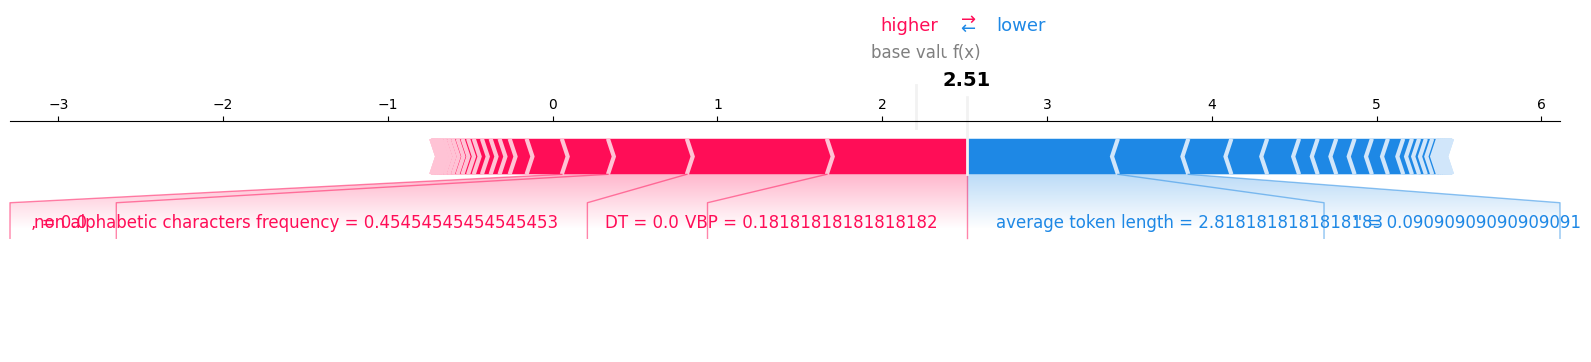

In [57]:
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
)
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

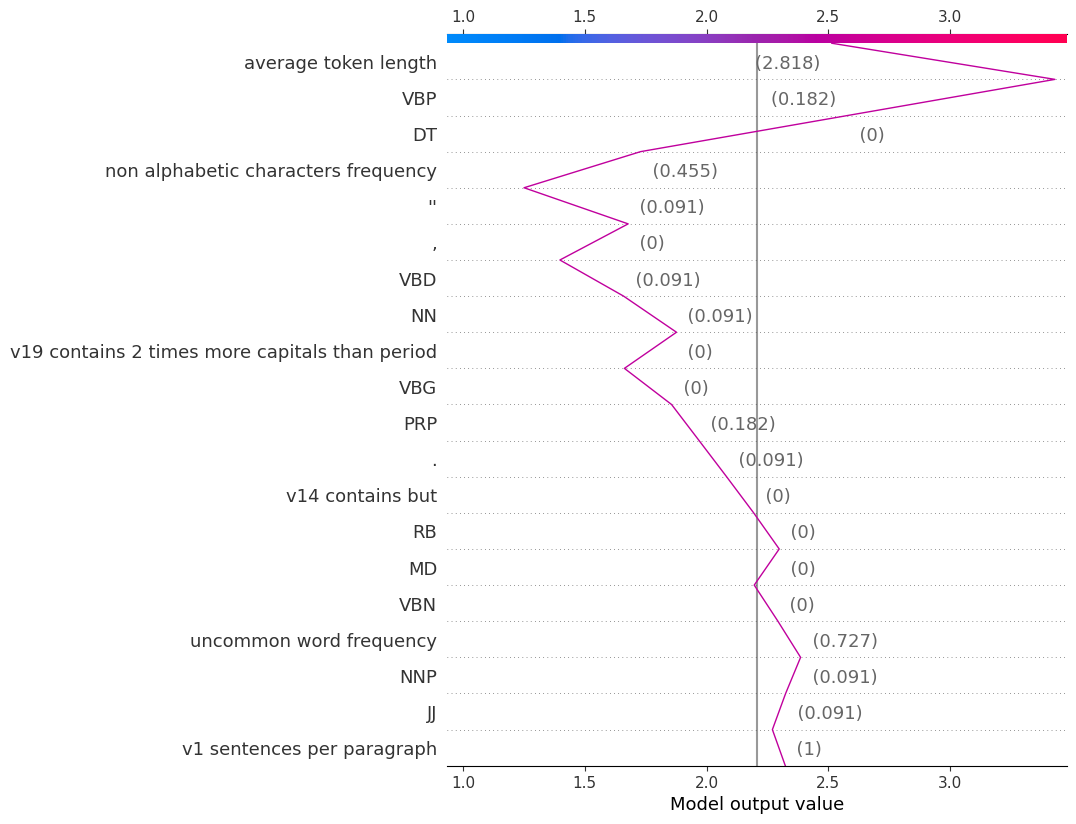

In [58]:
shap.decision_plot(
    shap_expected_val,  # type: ignore
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

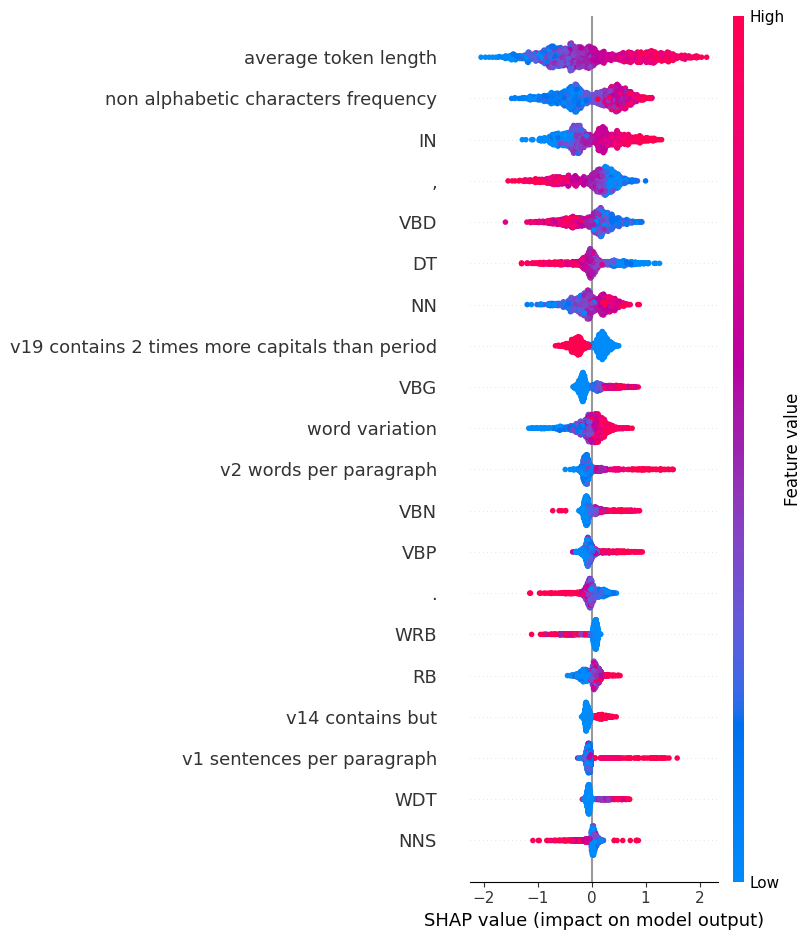

In [59]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


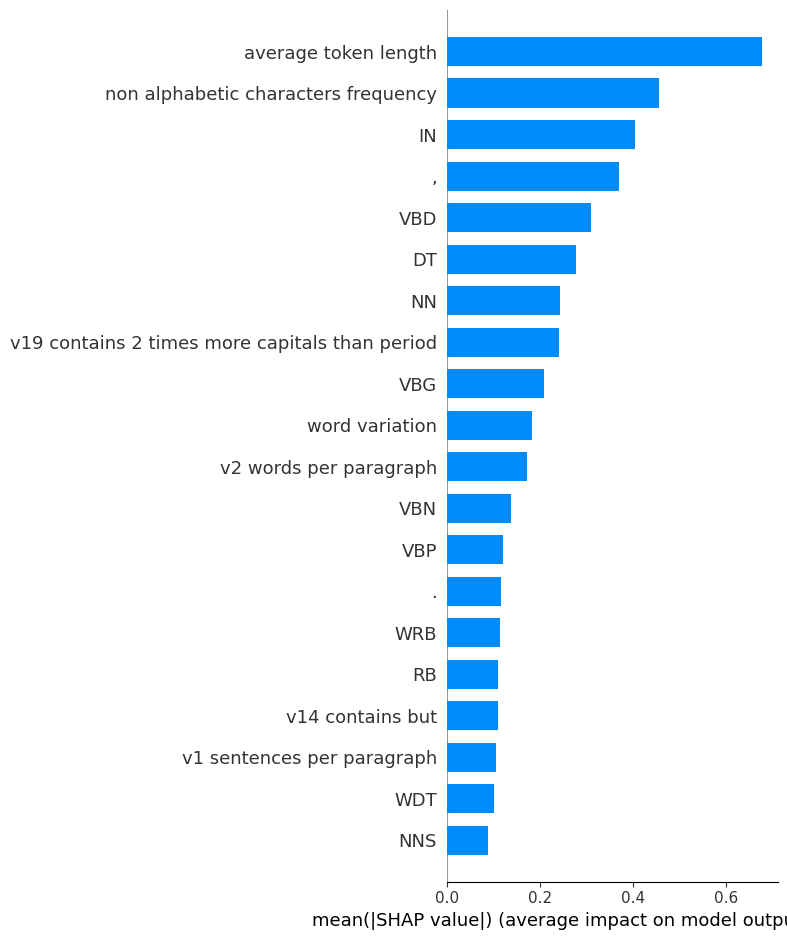

In [60]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()